The goal of this notebook is to automatically generate and solve Laplace integral problems to create a training set for a LLM.

# Imports

In [ ]:
import sympy as sp
from sympy import diff, solve, N, limit, latex
import numpy as np
import random
from IPython.display import display, Math
from scipy.optimize import dual_annealing
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Functions to generate laplace integrals

Here are the functions that we use to generate random Laplace integrals. The rest of the methods are fairly robust, so if we would like to train the LLM on a more general class of Laplace integrals later, we can simply alter these functions. The only constraint is that we cannot generate f(t) or g(t) that diverge within the bounds of the integral.

In [ ]:
### Generate random functions ###

def generate_linear_combination(max_num_terms):

  """
  This function generates a random linear combination of the sympy functions
  specified in the dictionary.
  """

  # Define the variable
  t = sp.symbols('t')

  # Define list of functions
  functions = np.array([
      1,
      sp.sin(t),
      sp.cos(t),
      sp.atan(t),
      #sp.sinc(t),
      t,
      t**2,
      t**3,
      t**4,
      t**5
      ])

  # Generate a random number of terms
  num_terms = random.randint(1, max_num_terms)

  # Generate random coefficients
  possible_coeffs = np.arange(-3, 3, 0.1)
  coefficients = np.round(np.random.choice(possible_coeffs, num_terms), 1)

  # Draw random indices
  indices = random.choices(range(len(functions)), k=num_terms)

  # If our function will just be a constant, redraw the index
  if len(indices) == 1 and indices[0] == 0:
    indices = random.choices(range(1, len(functions)), k=1)

  # Get linear conbinations of these functions
  f = sum(coefficients * functions[indices])

  return f

In [ ]:
### Define a function to generate the bounds of the integral ###
def generate_bounds(range):

  """
  This function generates bounds within a given range.

  range: [lower, upper]
  """

  # Get possible bounds on range
  possible_bounds = np.arange(range[0], range[1], 0.1)

  # Draw bounds
  bounds = np.random.choice(possible_bounds, 2, replace=False)

  # Get lower, upper bound
  lower = np.min(bounds)
  upper = np.max(bounds)

  return np.round(lower, 1), np.round(upper, 1)

In [ ]:
### Generate Laplace integral ###

def generate_integral(function_generator, bounds_generator, max_num_terms, range):

  """
  This function generates all the components of a Laplace integral given
  the various generator functions.

  It returns ((lower, upper), g(t), f(t), sign) where the integral
  is given by \int_{lower}^{upper} g(t) e^{sign * x * f(t)} dt

  function_generator: function that generates f, g
  bounds_generator: function that generates bounds
  max_num_terms: most terms the function could have
  range: range within which bounds fall
  """

  # Generate f(t), g(t)
  f = function_generator(max_num_terms)
  g = function_generator(max_num_terms)

  # Generate bounds
  bounds = bounds_generator(range)

  # Generate sign
  sign = -1 if random.random() < 0.5 else 1

  return bounds, g, f, sign

# Functions to find the minimum of f(t)

Here, we define functions to find the minimum of f(t) within specified bounds.We first attempt to find it analytically using SymPy. If this fails, we use 5 iterations of dual annealing to find it numerically. This should be fairly robust, even in the face of rapidly oscillating functions with multiple minima. However, if there are functions that have >5 minima within the bounds, this will of course not find them all. So, if we make the integral generation significantly more complex in the future, we may have to edit this slightly.

In [76]:
### Define a function to determine whether we can find the global minima of f analytically ###

def analytical_critical_pts(f, lower, upper):

  """
  This function determines whether we can find the global minima of f within
  the specified bounds analytically using sympy.

  If solveset returns an empty set or only a finite set, then sympy was able
  to solve for the critical points analytically. If it returns anything else,
  sympy was not able to find all critical points analytically.

  This returns a list of all the critical points the critical points if sympy
  could all of them analytically. To distinguish between an empty list that
  implies no critical points and one that implies no analytical solution, we also
  return a 0 if sympy could not find analytical solutions and a 1 if it could.
  """

  # Define symbol for t
  t = sp.symbols('t')

  # Define bounds in sympy
  domain = sp.Interval(lower, upper)

  # Get local minima
  solutions = sp.solveset(diff(f, t), t, domain=domain)

  # Check if the solutions are the empty set
  if solutions == sp.EmptySet:
   return [], 1

  # Check if the solutions a finite set
  elif isinstance(solutions, sp.FiniteSet):
    return list(solutions), 1

  # If it's anything else, solveset got no analytical insights
  else:
    return [], 0

In [77]:
## Define function to find minima numerically using many iterations of dual annealing
def find_minima_numerically(f, lower, upper, num_start_pts=5):

  """
  This function uses the dual annealing algorithm to find the minima of f on
  the specified bounds.

  f: sympy expression for the function to minimize
  lower: lower bound, float
  upper: upper bound, float
  num_start_pts: the number of times to run the dual annealing algorithm. default=5
  """

  # Format bounds for dual annealing
  bounds = [(lower, upper)]

  # Define list of starting points to increase the chance of finding all global minima
  start_pts = np.linspace(lower, upper, num_start_pts)

  # Define list to store global minima
  min_points = []

  # Run dual annealing from each starting point to increase chance of finding all global minima
  for start in start_pts:
      result = dual_annealing(lambda x: float(N(f.subs('t', x[0]))), bounds, x0=[start])
      min_points.append(round(result.x[0],4))  # round to 4 decimal pts bc algorithm results vary slightly

  # Take only unique minima
  min_points = list(set(min_points))

  return min_points

In [78]:
### Define function to find the global minima of f within the bounds, analytically or numerically ###
def find_global_min(f, bounds):

  """
  This function finds the global minima of f within the bounds. It also records
  whether or not the global minima were found analytically for future response
  generation purposes. It also returns the critical points, if we could find
  them analytically, for the same purpose.
  """

  # Define symbol
  t = sp.symbols('t')

  # Extract bounds
  lower, upper = bounds

  ## Attempt to find critical points analytically
  critical_points, complete = analytical_critical_pts(f, lower, upper)


  ## If this is a complete list of critical points, find the global minimum
  if complete:

    # Record that we could find minimum analytically
    analytic_min = True

    # Evaluate the function at the critical points and the endpoints
    critical_values = [(N(f.subs(t, point)), point) for point in critical_points if lower <= point <= upper]
    endpoint_values = [(N(f.subs(t, lower)), lower), (N(f.subs(t, upper)), upper)]

    # Combine the lists and find the minimum value(s)
    values = critical_values + endpoint_values
    min_value = min(v[0] for v in values)
    min_points = [v[1] for v in values if v[0] == min_value]

    return min_points, analytic_min, critical_points


  ## If it is not a complete list, look for the global minimum numerically
  else:

    # Record that we could not find minimum analytically
    analytic_min = False

    # Get minima numerically with dual annealing
    min_points = find_minima_numerically(f, lower, upper, num_start_pts=5)

    return min_points, analytic_min, None

# Functions to analytically approximate laplace integrals

Here we define functions to return the approximation for the laplace integral by using the formulae derived in class. They also return any imformation needed for prompt generation.

In [79]:
### Define function to approximate laplace integral if f(t) has a single minimum ###
def single_min_laplace_integral(bounds, g, f, sign, minimum):

  """
  This function returns the analytical formula for the approximation of a laplace
  integral given the single minimum of f(t). This will be used in the final
  laplace integral function in the case that f(t) has one minimum within the
  bounds. It also returns whether or not the minimum/maximum
  of f(t) was on the bounds of the integral, and if it is, which bound,
  as we will use this in our response generation.
  """

  # Define symbols
  t, x = sp.symbols("t x")

  # Deal with sympy zero class, which is not compatible with numpy
  if minimum == sp.S.Zero:
    minimum = 0.0

  # Get f(min), g(min). Use limits to avoid division by 0 issues
  f_t0 = limit(f, t, minimum)
  g_t0 = limit(g, t, minimum)

  # If the minimum is on a bound
  if minimum in np.round(bounds, 4):  # must round bounds to 4 decimal places bc minimum is rounded too

    # Get f'(min)
    fp_t0 = limit(diff(f,t), t, minimum)

    # Record the min/max is on bounds
    minmax_on_bounds = True

    # Record which bound it is
    if minimum == np.round(bounds, 5)[0]:
      which_bound = "a"
    else:
      which_bound = "b"

    # Approximation when minimum is on the bound
    return g_t0 * sp.exp(sign * x * f_t0) / (sp.Abs(fp_t0) * x), minmax_on_bounds, which_bound

  # Minimum is within bounds
  else:

    # Record the min/max is not on bounds
    minmax_on_bounds = False

    # Get f''(min)
    fpp_t0 = limit(diff(f,t,2), t, minimum)  # take the limit in case L'Hopital needed

    # Approximation when minimum is within interval
    return sp.sqrt(sp.pi) * g_t0 * sp.exp(sign * x * f_t0) * sp.sqrt(2 / (sp.Abs(fpp_t0) * x)), minmax_on_bounds, None

In [80]:
### Define function to analytically approximate laplace integrals ###

def approximate_laplace_integral(bounds, g, f, sign):

  """
  This function returns an analytical approximation for the Laplace
  integral defined by \int_{lower}^{upper} g(t) e^{sign * x * f(t)} dt
  in the limit of large x. It also returns whether or not the minimum/maximum
  of f(t) was on the bounds of the integral, and how many minima/maxima there
  were, and whether or not they were found analytically, the global min/maxima,
  and the critical points (if it was found analytically), and which bound the
  min/max is on, if it is on a bound. We will use this in our response generation
  later.
  """

  # Define symbols
  t, x = sp.symbols("t x")

  # If the sign is positive, multiple f by -1 so minimization maximizes f
  if sign == 1:
    f = -1 * f

  # Find the global minimum of f within the bounds
  minima, analytic_min, critical_points = find_global_min(f, bounds)

  # If sign is positive, multiply f by -1 to return it to normal
  if sign == 1:
    f = -1 * f

  # Check for edge case where find_global_min function does not return any values
  if len(minima) == 0:
    return ValueError("Minima function returned no values")

  # If there is only one minimum
  elif len(minima) == 1:

    # Get analytical approximation using the single min laplace integral approximation
    approximation, minmax_on_bounds, which_bound = single_min_laplace_integral(bounds, g, f, sign, minima[0])

    # Record number of min/max
    num_minmax = 1

    return approximation, minmax_on_bounds, num_minmax, analytic_min, minima, critical_points, which_bound

  # If there is more than minimum, imagine breaking the integration interval in pieces. Apply single minimum approximation to each
  else:

    # Record number of min/max
    num_minmax = len(minima)

    # Initialize variable to hold final approximation
    approximation = 0

    # Loop through each set of bounds, adding contribution to integral from single minimum formula
    for i in range(num_minmax):

      # Add approx from single minimum approximation formula
      approximation += single_min_laplace_integral(bounds, g, f, sign, minima[i])[0]

    # Record that min/max likely not on bounds (true except in very extreme case)
    minmax_on_bounds = False

  return approximation, minmax_on_bounds, num_minmax, analytic_min, minima, critical_points, None

# Functions to compare approximation to numerical solution

Here we define function to compare the analytical approximation to the numerical solution.

In [ ]:
## Define function to evaluate the analytical approximation at given x values
def evaluate_analytical(analytical_approximation, xs, max_val=np.inf):

  """
  This function evaluates the analytical approximation for each x
  value in the array xs. It returns an array containing the results.

  Specify a maximum value allowed in the array to avoid the matplotlib
  plotting issues that arise for values above 10^100.

  analytical_approximation: sympy expression for your approximation
  xs: array of x values at which we evaluate the approximation
  max_val: maximum value allowed in the return array
  """

  approx_vals = np.array([analytical_approximation.subs(x, x_val).evalf() \
                for x_val in xs \
                if np.abs(analytical_approximation.subs(x, x_val).evalf()) < max_val])

  return approx_vals

In [119]:
## Perform numerical integration of laplace integral for set of x values
def integrate_numerically(bounds, g, f, sign, xs, max_error):

  """
  This function finds the solution to the Laplace integral defined by f, g, sign,
  and bounds for each x in the array xs. It truncates any computation if the
  integration error exceeds max_error. It returns an array of the numerical results.

  bounds: tuple (a, b), bounds of the laplace integral
  g: sympy expression for g(t)
  f: sympy expression for f(t)
  xs: array of x values at which we evaluate the integral
  max_error: the maximum integration error allowed before we stop computation
  """

  # Define the function you want to integrate
  integrand = g * sp.exp(sign*x*f)

  # Define the function you want to integrate
  def evaluate_integrand(x_val, t_val):
      return integrand.subs(x,x_val).subs(t,t_val).evalf()

  # Define bounds over which we want to integrate
  lower, upper = bounds

  # Initialize array to store integration data
  numerical_vals = np.zeros(len(xs))
  numerical_vals[:] = np.nan

  # Calculate integral for each lambda
  for idx, x_val in enumerate(xs):

    # Perform integration
    integral, error = quad(lambda t: evaluate_integrand(x_val, t), lower, upper)

    # Save data
    numerical_vals[idx] = integral

    # Stop if quad breaks
    if error > max_error:
      break

  return numerical_vals

In [23]:
# Plot results
def plot_results(approx_vals, numerical_vals, xs):

  """
  This function plots the numerical solution and the analytical approximation
  given an array of values for each.

  approx_vals: array of values given by the analytical approximation
  numerical_vals: array of values given by the numerical integration
  xs: array of x values at which we computed the integral
  """

  # Get length of numerical_vals array
  len_num_vals = len(numerical_vals)
  len_approx_vals = len(approx_vals)

  # Set up plotting
  plt.figure(figsize=(10,6))
  plt.rcParams.update({'font.size': 22})

  # Plot approximation and numerical solution
  plt.loglog(xs[:len_approx_vals], np.abs(approx_vals), \
             linewidth=4, label="approximation")
  plt.loglog(xs[:len_num_vals], np.abs(numerical_vals), \
             'o', mfc='none', markersize=8, label='numerical')

  # Set up legend, title, x label
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.title("Testing result")
  plt.xlabel("x")

# Testing Results

This section of the notebook allows us to quickly test our results. We quantitatively test our approximation accuracy in the next section.

In [ ]:
# Define symbols
x, t = sp.symbols('x t')

# Generate integral
bounds, g, f, sign = generate_integral(generate_linear_combination, generate_bounds, max_num_terms=5, range=[-1,1])

# Print integral
print("Generated Integral \n")
integral = sp.Integral(g * sp.exp(sign*x*f), (t, bounds[0], bounds[1]))
latex_integral = sp.latex(integral)
display(Math(latex_integral))

# Generate approximation
approximation = approximate_laplace_integral(bounds, g, f, sign)[0]

# Print approximation
print("\n Approximation \n")
approximation

Generated Integral 



<IPython.core.display.Math object>


 Approximation 



0.0468417379426615*exp(-0.247196007418816*x)/x

In [ ]:
## Compare analytical approximation and numerical solution

# Define array of xs to test on
xs = np.logspace(-1, 3, 300)

# Get analytical approximation
approx_vals = evaluate_analytical(approximation, xs, max_val=10**100)

# Get numerical solution
numerical_vals = integrate_numerically(bounds, g, f, sign, xs, max_error=1000)

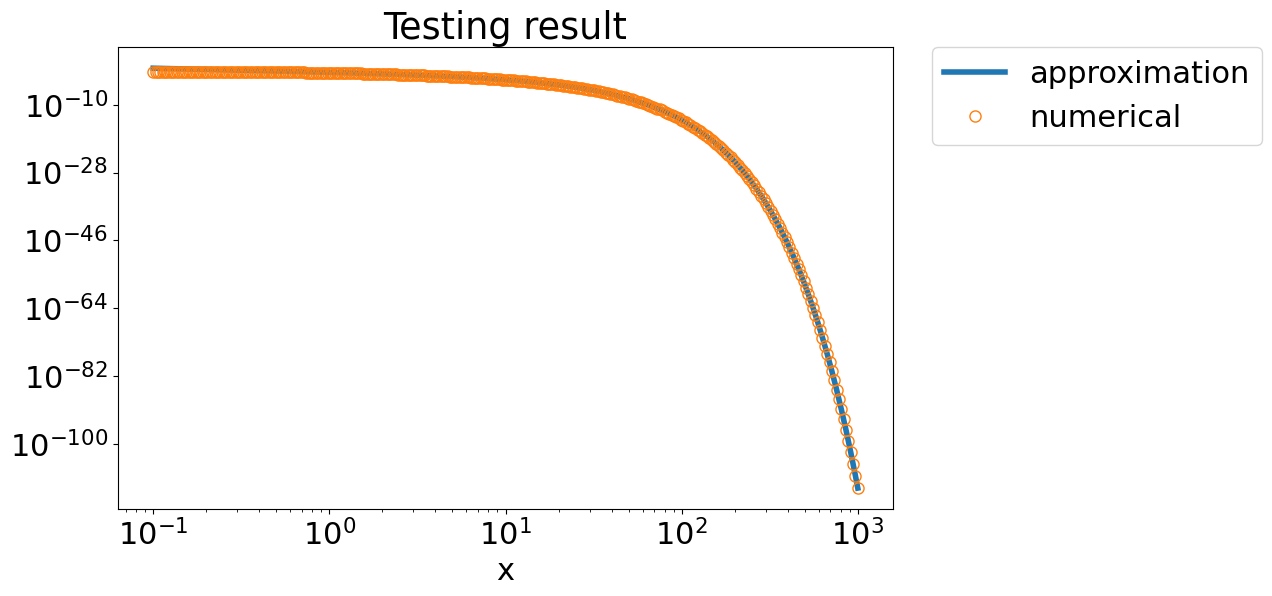

In [ ]:
# Plot results
plot_results(approx_vals, numerical_vals, xs)

# Generating prompts & solutions

In this section, we provide functions that generate prompts and solutions, and finally, an entire dataset.

## Functions

Here we define the functions that we will use to generate the Latex prompts and solutions. Note that to load these prompts and responses in latex, the packages

```
\usepackage{minted}
\usepackage{amsmath}
```


are required.

In [ ]:
import inspect

## Define function to return latex code of a python function
def function_to_latex(func):

    # Get the source code
    source_code = inspect.getsource(func)

    # Escape special characters
    source_code = source_code.replace("\\", "\\\\")
    source_code = source_code.replace("{", "\\{")
    source_code = source_code.replace("}", "\\}")

    # Wrap the source code in a minted environment
    latex_code = "\\begin{minted}{python}\n" + source_code + "\\end{minted}\n"

    return latex_code

In [ ]:
## Define function to generate prompt and integral
def generate_problem():

  """
  This function generates a problem statement and returns the statement as well
  as the parameters of the integral used in the approximation function.
  """

  # Generate integral
  bounds, g, f, sign = generate_integral(generate_linear_combination, generate_bounds, max_num_terms=5, range=[-1,1])

  # Formatting problem statement
  if sign == 1:
    show_sign = "+"
  else:
    show_sign = "-"

  # Get problem statement
  statement = f"Consider the integral \\par "\
              f"\\begin{{equation}} I(x) = \\int_{{{bounds[0]}}}^{{{bounds[1]}}} ({latex(g)}) e^{{{show_sign} x ({latex(f)})}} \\, dt \\end{{equation}} \\par"\
              f" Develop an analytical formula for $I(x)$ that is accurate as $x \\to \\infty$. Compare your answer to numerical simulations of the integral."

  return bounds, g, f, sign, statement

In [135]:
## Define function to approximation and response
def get_solution(bounds, g, f, sign):

  """
  This function takes in the parameters of the Laplace integral and returns an
  analytical approximation as well as a response statement.
  """

  # Determine whether we will look for min or max of f
  if sign == 1:
    minmax = "maximum"
    small_large = "largest"
    show_sign = "+"
  else:
    minmax = "minimum"
    small_large = "smallest"
    show_sign = "-"

  statement = f"The integral is of the form \\begin{{equation}} I(x) = \\int_{{a}}^{{b}} g(t) e^{{{show_sign} x f(t)}} \\, dt \\end{{equation}} \\par "\
              f"where $a={bounds[0]}$, $b={bounds[1]}$, $g(t) = {latex(g)}$, and $f(t) = {latex(f)}$. "\
              f"This means we can use Laplace’s method to develop an analytical approximation in the limit that $x \\to \\infty$. \\par "\
              f"In this limit, the integral will be dominated by the integrand near the {minmax} of $f(t)$ within the bounds $[{bounds[0]}, {bounds[1]}]$. "\
              f"So, to simplify the integral, we will expand the integrand around this {minmax}. \\par "

  # Get the analytical approximation of the integral, specifying whether the min/max was on the bounds, if not how many min/max there were
  approximation, minmax_on_bounds, num_minmax, analytic_min, minima, critical_points, which_bound = approximate_laplace_integral(bounds, g, f, sign)

  # Statement for the case where we could find the min/max of f analytically
  if analytic_min:

    statement += f"In this case, we can find the {minmax} of $f(t) = {latex(f)}$ on the interval analytically. We begin by looking for critical point(s) $t_{{crit}}$ of $f(t)$ by solving $f’(t) = {latex(diff(f, t))} = 0$ for $t$. "

    # If critical points were not found.
    if len(critical_points) == 0:

      statement += f"We find that there are no critical points of $f(t) \\in {bounds[0], bounds[1]}$. This means that its {minmax} must be on the bounds. "\
                   f"Comparing the values of $f(t)$ on the bounds, we find that its {minmax} occurs at $t_0 = {which_bound} = {minima[0]}$. \\par "

    # If they were
    else:

      statement += f"This gives us that $t_{{crit}} = {critical_points}$. To find the {minmax} on this interval, we evaluate $f(t)$ at the critical point(s) $t_{{crit}}$ and the bounds ${bounds[0]}$ and ${bounds[1]}$. "\
                   f"We take the $t$ that gives the {small_large} value. Here, this {minmax} $t_0 = {minima}$. \\par "


  # Statement for numerical case
  else:

    # Statement & code
    statement += f"However, it is impossible to compute the {minmax} of $f(t)$ on the bounds analytically. We must approximate it numerically. "\
                 f"We will use the a few iterations of the dual annealing algorithm to achieve this. The code below implements dual annealing. \\par "\
                 f"\\begin{{minted}}{{python}}\n import sympy as sp \n from sympy import N \n import numpy as np \n from scipy.optimize import dual_annealing \n \\end{{minted}}\n "\
                 f"{function_to_latex(find_minima_numerically)}"\
                 f"\nUsing a few iterations of dual annealing, we find that the {minmax} of $f(t)$ occurs at $t_0 = {minima}$. \\par "


  # Statement for case of min/max on bounds of integral
  if minmax_on_bounds:

    statement += f"Since the integral is dominated by the value of the integrand near {which_bound}, we Taylor expand the integrand around this point. "\
                 f"\\begin{{equation}} I(x) =  \\int_{{a}}^{{b}} (g({which_bound}) + (t-{which_bound})g'({which_bound})+...) e^{{{show_sign} x (f({which_bound}) + (t-{which_bound}) f’({which_bound}) + ...)}} \\, dt \\end{{equation}} "\
                 f"We can then approximate \\begin{{equation}} I(x) \\approx \\int_{{a}}^{{b}} g({which_bound}) e^{{{show_sign} x (f({which_bound}) + (t-{which_bound}) f’({which_bound}))}} \\, dt \\end{{equation}} "\
                 f"Pulling out the constant in the integral gives "\
                 f"\\begin{{equation}} I(x) \\approx g({which_bound}) e^{{{show_sign} x f({which_bound})}} \\int_{{a}}^{{b}} e^{{{show_sign} x (t-{which_bound}) f’({which_bound})}}  \\, dt \\end{{equation}} \\par "\

    # Case where bound is lower bound
    if which_bound == "a":

      # Add additional comment if sign is positive for clarity, since there is a technicality when taking the absolute value
      if sign == -1:
        statement += f"Since $x$ is large, we perform the change of variables $u = x (t-{which_bound}) |f’({which_bound})|$, rewriting the integral as "
      else:
        statement += f"Since $x$ is large, we perform the change of variables $u = x (t-{which_bound}) |f’({which_bound})|$. Note $f’({which_bound}) < 0$ since it is a maximum. So, rewriting the integral, we get "

      statement += f"\\begin{{equation}} I(x) \\approx g(a) e^{{{show_sign} x f(a)}} \\int_{{0}}^{{x (b-a) |f’(a)|}} \\frac{{1}}{{x |f’(a)|}} e^{{-u}} \\, dt \\end{{equation}} "\
                   f"Since $x \\to \\infty$, we approximate this with new bounds as "\
                   f"\\begin{{equation}} I(x) \\approx g(a) e^{{{show_sign} x f(a)}} \\frac{{1}}{{x |f’(a)|}} \\int_{{0}}^{{\\infty}} e^{{-u}} \\, dt \\end{{equation}} \\par "\
                   f"Solving the integral and evaluating, we find that \\par "\
                   f"\\begin{{equation}} \\boxed{{I(x) \\approx {latex(approximation)}}} \\end{{equation}} "

    # Case where bound is upper bound
    else:

      # Add additional comment if sign is positive for clarity, since there is a technicality when taking the absolute value
      if sign == -1:
        statement += f"Since $x$ is large, we perform the change of variables $u = x (t-{which_bound}) |f’({which_bound})|$. Note $f’({which_bound}) < 0$ since it is a minimum. So, rewriting the integral, we get "
      else:
        statement += f"Since $x$ is large, we perform the change of variables $u = x (t-{which_bound}) |f’({which_bound})|$, rewriting the integral as "


      statement += f"\\begin{{equation}} I(x) \\approx g(b) e^{{{show_sign} x f(b)}} \\int_{{x (a-b) |f’(b)|}}^{{0}} \\frac{{1}}{{x |f’(b)|}} e^{{u}} \\, dt \\end{{equation}} "\
                   f"Since $x \\to \\infty$, we approximate this with new bounds as "\
                   f"\\begin{{equation}} I(x) \\approx g(b) e^{{{show_sign} x f(b)}} \\frac{{1}}{{x |f’(b)|}} \\int_{{-\\infty}}^{{0}} e^{{u}} \\, dt \\end{{equation}} \\par "\
                   f"Solving the integral and evaluating, we find that \\par "\
                   f"\\begin{{equation}} \\boxed{{I(x) \\approx {latex(approximation)}}} \\end{{equation}} "

  # Statement for case where min/max not on bounds
  else:

    statement += f"Since the integral is dominated by the value of the integrand near {minima[0]}, we Taylor expand the integrand around this point. "\
                 f"\\begin{{equation}} I(x) =  \\int_{{a}}^{{b}} (g({minima[0]}) + (t-{minima[0]})g'({minima[0]})+...) e^{{{show_sign} x (f({minima[0]}) + (t-{minima[0]}) f’({minima[0]}) + \\frac{{(t-{minima[0]})^2}}{{2}} f''({minima[0]}) +...)}} \\end{{equation}}"\
                 f"But $f’({minima[0]}) = 0$ by definition, so we can remove this term from the exponent. We can then approximate \\begin{{equation}} I(x) \\approx \\int_{{a}}^{{b}} g({minima[0]}) e^{{{show_sign} x (f({minima[0]}) + \\frac{{(t-{minima[0]})^2}}{{2}} f’’({minima[0]}))}} \\, dt \\end{{equation}} \\par "\
                 f"Which equals \\par "\
                 f"\\begin{{equation}} = g({minima[0]}) e^{{{show_sign} x f({minima[0]})}} \\int_{{a}}^{{b}} e^{{{show_sign} x (\\frac{{(t-{minima[0]})^2}}{{2}} f’’({minima[0]}))}} \\, dt \\end{{equation}} \\par "\
                 f"Because $x$ is large, we perform the change of variables $u = \\sqrt{{x \\frac{{|f’’({minima[0]})|}}{{2}}}}(t-{minima[0]})$, rewriting the integral as "\
                 f"\\begin{{equation}} g({minima[0]}) e^{{{show_sign} x f({minima[0]})}} \\int_{{\\sqrt{{x \\frac{{|f’’({minima[0]})|}}{{2}}}} (a-{minima[0]})}}^{{\\sqrt{{x \\frac{{|f’’({minima[0]})|}}{{2}}}} (b-{minima[0]})}} \\sqrt{{\\frac{{2}}{{x |f’’({minima[0]})|}}}} e^{{-u^2}} \\, dt \\end{{equation}} \\par "\
                 f"Since $x \\to \\infty$, we approximate this as "\
                 f"\\begin{{equation}} g({minima[0]}) e^{{{show_sign} x f({minima[0]})}} \\sqrt{{\\frac{{2}}{{x |f’’({minima[0]})|}} }} \\int_{{-\\infty}}^{{\\infty}} e^{{-u^2}} \\, dt \\end{{equation}} \\par "

    # Case where there was one min/max
    if num_minmax == 1:

      statement += f"Solving the integral and evaluating, we find that \\par "\
                   f"\\begin{{equation}} \\boxed{{I(x) \\approx {latex(approximation)}}} \\end{{equation}}"

    # Case where there were multiple
    else:

      statement += f"Note that here, while we ignored them in the work above, there were actually multiple $t_0$ values. "\
                   f"This means that to get the final approximation, we need to add up all the contributions of this form, one for each peak of the integrand near each $t_0$. \\par "\
                   f"Summing up all these contributions and evaluating gives us a final approximation of \\par "\
                   f"\\begin{{equation}} \\boxed{{I(x) \\approx {latex(approximation)}}} \\end{{equation}}"


  # Numerical comparison statement
  statement += f"One can now compare this analytical approximation to the numerical solution. To do this, we use Scipy’s quad function to compute $I(x)$ for an array of $x$ values. "\
               f"The function below implements this numerical integration, stopping early if the error becomes too large.\n"

  # Add code to integrate numerically
  statement += f"\\begin{{minted}}{{python}}\n import sympy as sp \n import numpy as np \n from scipy.integrate import quad \n \\end{{minted}}\n "
  statement += function_to_latex(integrate_numerically)

  statement += "\nOne can also evaluate the analytical approximation at each $x$ using this function. \n"

  # Add code to evaluate analytical approximation
  statement += f"\\begin{{minted}}{{python}}\n import sympy as sp \n import numpy as np \n \\end{{minted}}\n "
  statement += function_to_latex(evaluate_analytical)

  statement += "\nOne can then plot both to compare the numerical solution to the analytical approximation.\n"

  # Add code to plot comparison
  statement += f"\\begin{{minted}}{{python}}\n import numpy as np \n import matplotlib.pyplot as plt \n \\end{{minted}}\n "
  statement += function_to_latex(plot_results)


  statement += "\nOne should see good comparison for large $x$!"

  return approximation, statement

In [60]:
## Define function to generate dataset
def generate_dataset(n, path, filename):

  """
  This function generates a csv file called filename with n prompts and solutions
  and saves it to the specified path.

  It excludes any approximations that give zero, as we need higher order terms
  to get any information from these integrals using the Laplace method.
  """

  data = []

  for i in range(n):

    # Generate integral and prompt
    bounds, g, f, sign, prompt = generate_problem()

    # Generate solution and statement
    approximation, solution = get_solution(bounds, g, f, sign)

    # Skip approximations that give zero. Laplace method to first order gives no information
    if approximation == 0:
      continue

    # Skip NaN approximations, which occur when f'(t_0) == 0 for t_0 on the bounds
    elif type(approximation) == sp.core.numbers.NaN:
      continue

    # Save
    data.append([prompt, solution])

    print(f"{i+1} complete")

  # Convert to array
  data = np.array(data)

  # Save array as csv file to path
  data = pd.DataFrame(data, columns=["Prompt", "Solution"])
  data.to_csv(path + filename, index=False)

  # Return data
  return data

## Testing

Here we test the prompt and solution generation.

### Qualitative test of approximation accuracy

Here we test prompt, response, and plot generation by inspection.

In [ ]:
# Generate integral and prompt
bounds, g, f, sign, prompt = generate_problem()

# Generate solution and statement
approximation, statement = get_solution(bounds, g, f, sign)

In [ ]:
prompt

'Consider the integral \\par \\begin{equation} I(x) = \\int_{-0.5}^{0.3} (0.7 t^{3} + 4.1 \\cos{\\left(t \\right)}) e^{+ x (1.3 t + 0.2 \\cos{\\left(t \\right)})} \\, dt \\end{equation} \\par Develop an analytical formula for $I(x)$ that is accurate as $x \\to \\infty$. Compare your answer to numerical simulations of the integral.'

In [ ]:
statement

'The integral is of the form \\begin{equation} I(x) = \\int_{a}^{b} g(t) e^{+ x f(t)} \\, dt \\end{equation} \\par Where $a=-0.5$, $b=0.3$, $g(t) = 0.7 t^{3} + 4.1 \\cos{\\left(t \\right)}$, and $f(t) = 1.3 t + 0.2 \\cos{\\left(t \\right)}$. This means we can use Laplace’s method to develop an analytical approximation in the limit that $x \\to \\infty$. \\par In this limit, the integral will be dominated by the integrand near the maximum of $f(t)$ within the bounds $[-0.5, 0.3]$. So, to simplify the integral, we will expand the integrand around this maximum. \\par In this case, we can find the maximum of $f(t) = 1.3 t + 0.2 \\cos{\\left(t \\right)}$ on the interval analytically. We find the critical point(s) $t_{crit}$ of $f(t)$ by solving $f’(t) = 1.3 - 0.2 \\sin{\\left(t \\right)} = 0$ for $t$. We find that there are no critical points of $f(t) \\in (-0.5, 0.3)$. This means that its maximum must be on the bounds. Comparing the values of $f(t)$ on the bounds, we find that its maximum 

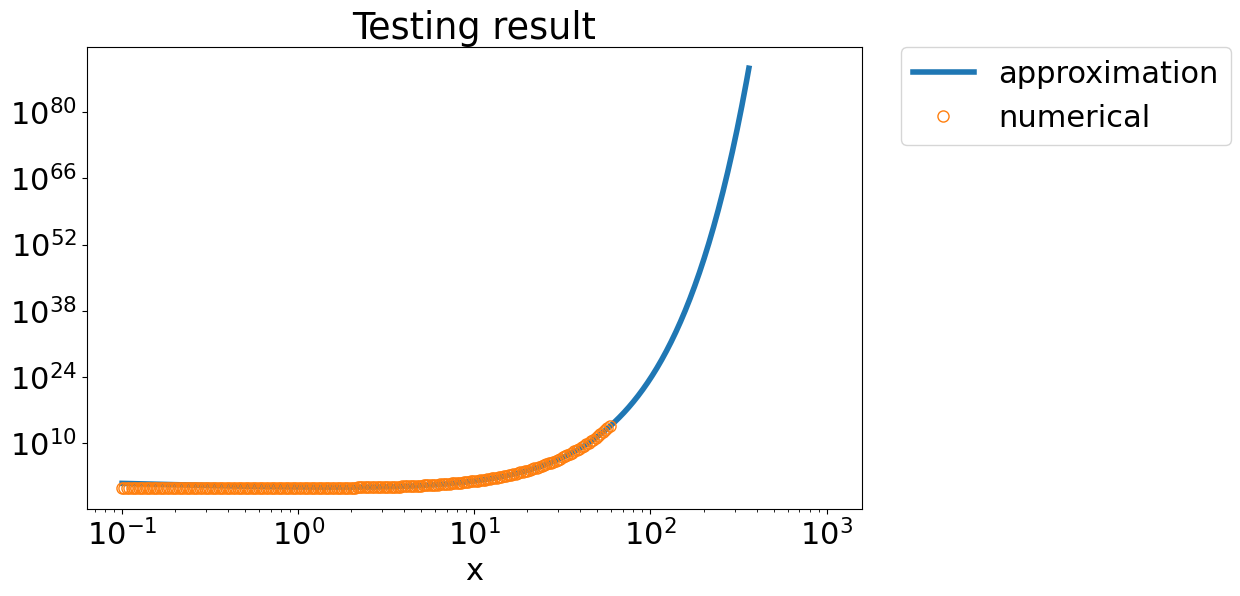

In [ ]:
## Compare analytical approximation and numerical solution

# Define array of xs to test on
xs = np.logspace(-1, 3, 300)

# Get analytical approximation
approx_vals = evaluate_analytical(approximation, xs, max_val=10**90)

# Get numerical solution
numerical_vals = integrate_numerically(bounds, g, f, sign, xs, max_error=1000)

# Plot results
plot_results(approx_vals, numerical_vals, xs)

### Quantitative test of approximation accuracy

Here, we use the absolute percent error between $I(x)$ and its approximation at the largest value of x we computed with reasonable numerical accuracy to get a rough quantitative estimate of the quality of our approximations.

In [81]:
## Define function to roughly quantify quality of approximation
def get_last_pct_error(approx_vals, numerical_vals):

  """
  This function gets the absolute percent error between the numerical values
  and the analytical approximation at the last point (ie the largest x value)
  for which numerical integration worked and was nonzero.
  """

  # Get index of last nonzero input to numerical vals
  non_zero_indices = np.nonzero(numerical_vals)
  last_non_zero_index = non_zero_indices[0][-1]

  # Get last numerical value
  last_num_val = numerical_vals[last_non_zero_index]

  # Get analytical value for this same x
  corresponding_approx = approx_vals[last_non_zero_index]

  # Return absolute pct error between them. Add a small number in the denominator to avoid division by zero
  return np.abs((corresponding_approx - last_num_val) / last_num_val)

In [110]:
## Get pct error from many approximations

# Define array of xs to test on
xs = np.logspace(-1, 3, 300)

# Save errors
errors = []

# Run through 25 approximations
for _ in range(25):

  # Generate integral and prompt
  bounds, g, f, sign, prompt = generate_problem()

  # Generate solution and statement
  approximation, statement = get_solution(bounds, g, f, sign)

  # Skip approximations that have f'(t_0) = 0 when t_0 on bounds
  if type(approximation) == sp.core.numbers.NaN:
    continue

  # Skip approximations that have g(t_0) = 0 since we need higher order terms for Laplace
  elif approximation == 0:
    continue

  # Get analytical approximation
  approx_vals = evaluate_analytical(approximation, xs, max_val=np.inf)

  # Get numerical solution
  numerical_vals = integrate_numerically(bounds, g, f, sign, xs, max_error=1000)

  # Get error
  error = get_last_pct_error(approx_vals, numerical_vals)

  # Save and print
  errors.append(error)
  print(error)

0.0216098995274465
0.0542741620456187
0.262532952406475
0.0330563680376599
0.0158002349360569
0.0118460982123547
3.30249625581114e-15
0.187567730658231
0.00991665473122933
0.0144780916149138
0.0451262557802874
0.0150912111743067
0.00787000782914251
0.244089683464404
0.0336237801613025
0.00227221089832750
0.000474342582535553
0.160862157204396
0.0385770328444239
0.115621344978776
0.0266154150495985
0.0264461559216349
0.00210045067227632
0.00525131587521894
0.000169581782420378


## Dataset generation

Here we generate a dataset! Note that it may take some time, as numerically finding the minimum of f(t) can be slow since we have made it robust to rapidly oscillating functions.

In [ ]:
## Generate dataset!

# Number of problems
n = 500

# Generate dataset
data = generate_dataset(n=n, path="/content/gdrive/My Drive/Third year/Apmth 201/laplace_integral_data/", filename="dataset2.csv")

1 complete
2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete
15 complete
16 complete
17 complete
18 complete
19 complete
20 complete
21 complete
22 complete
23 complete
24 complete
25 complete
26 complete
27 complete
28 complete
29 complete
30 complete
31 complete
32 complete
33 complete
34 complete
35 complete
37 complete
38 complete
39 complete
41 complete
42 complete
43 complete
44 complete
45 complete
46 complete
47 complete
48 complete
49 complete
50 complete
51 complete
52 complete
53 complete
54 complete
55 complete
57 complete
58 complete
59 complete
60 complete
62 complete
63 complete
64 complete
65 complete
66 complete
67 complete
68 complete
69 complete
70 complete
71 complete
72 complete
73 complete
74 complete
75 complete
77 complete
79 complete
80 complete
81 complete
82 complete
83 complete
84 complete
85 complete
86 complete
87 complete
88 complete
89 complete
90 complete
9